# Simulation 3b: Bayesian Logistic Regression, preconditioned case
This is code to support simulations in the paper "Log-concave sampling: Metropolis-Hastings algorithms are fast!"

by Raaz Dwivedi, Yuansi Chen, Martin J. Wainwright, Bin Yu

In [1]:
# load necessary packages
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# load our packages
import mcmc
import plot_basic # basic setting for plots in matplotlib

### Density of Bayesian logistic regression in the preconditioned case
$$
f(\theta) = - Y^\top X \theta + \sum_{i=1}^n \log(1+e^{\theta^\top X_i}) + \frac{\lambda}{2} \|\Sigma_X^{1/2} \theta\|^2 \\
\nabla f(\theta) = - X^\top Y + \sum_{i=1}^n \frac{X_i}{1 + e^{-\theta^\top X_i}} + \lambda \Sigma_X \theta \\
g(\theta) = f(\Sigma^{-1/2}\theta)\\
\nabla g(\theta) = \Sigma^{-1/2} \nabla f(\Sigma^{-1/2}\theta)
$$

In [2]:
# define the logconcave function: Bayesian logistic regression in the unconditioned case first
def f(theta, X, Y, lam=1.):
    """
    theta is of dimension nb_exps * d
    X is of dimension n * d
    Y is of dimension n
    """
    # h is of dimension nb_exps * n
    h = theta.dot(X.T)
    return - h.dot(Y) + np.sum(np.log(1. + np.exp(h)), axis=1) + lam / 2 * np.mean(h * h, axis = 1)

# density of f up to a constant
def density_f(theta, X, Y, lam=1.):
    return  np.exp(-f(theta, X, Y, lam))

# gradient of f up to a constant
def grad_f(theta, X, Y, lam):
    """
    theta is of dimension nb_exps * d
    X is of dimension n * d
    Y is of dimension n
    """
    # h is of dimension nb_exps * n
    h = theta.dot(X.T)
    # grad is of dimension nb_exps * d
    return - X.T.dot(Y) + np.sum(X.T/(1+np.exp(-h))[:, np.newaxis, :], axis=2) +  1./Y.shape[0]*lam * h.dot(X) 

# define the logconcave function in the precondioned case
def g(theta, X, Y, lam=1., SigmaSqrtInv=None):
    """
    theta is of dimension nb_exps * d
    X is of dimension n * d
    Y is of dimension n
    """
    if SigmaSqrtInv is None:
        # calculating the inverse sqrt of Sigma
        U, S, V = np.linalg.svd(X/np.sqrt(Y.shape[0]), full_matrices=0)
        SigmaSqrtInv = V.T.dot(np.diag(1./S)).dot(V)
    
    return f(theta.dot(SigmaSqrtInv), X, Y, lam)

# density of g up to a constant
def density_g(theta, X, Y, lam=1., SigmaSqrtInv=None):
    return  np.exp(-g(theta, X, Y, lam, SigmaSqrtInv))


# gradient of g up to a constant
def grad_g(theta, X, Y, lam=1., SigmaSqrtInv=None):
    """
    theta is of dimension nb_exps * d
    X is of dimension n * d
    Y is of dimension n
    """
    if SigmaSqrtInv is None:
        # calculating the inverse sqrt of Sigma
        U, S, V = np.linalg.svd(X/np.sqrt(Y.shape[0]), full_matrices=0)
        SigmaSqrtInv = V.T.dot(np.diag(1./S)).dot(V)
    
    # grad is of dimension nb_exps * d
    return grad_f(theta.dot(SigmaSqrtInv), X, Y, lam).dot(SigmaSqrtInv)


In [3]:
np.random.seed(123456)

# dimensions
ds = np.array([2])
# number of iterations
nb_iters = 4000
# number of samples
nb_exps = 2500
# number of training data samples
n = 50

error_ula_all = np.zeros((ds.shape[0], nb_iters, 1))
error_ula_02_all = np.zeros((ds.shape[0], nb_iters, 1))
error_ula_002_all = np.zeros((ds.shape[0], nb_iters, 1))
error_mala_all = np.zeros((ds.shape[0], nb_iters, 1))
error_rwmh_all = np.zeros((ds.shape[0], nb_iters, 1))

# save to the following path: modify before use
save_path = '/Users/yuansi.chen/UCB/STAT_2017/Writing/MALA/mala_code_public/mala_public/fig/'

In [4]:
np.random.seed(123456)

for j, d in enumerate(ds):
    lam = 3.*d/np.pi**2
    # data generation
    X = np.random.binomial(1, 0.5, (n, d)) * 2 -1
    X = X/np.sqrt((X * X).mean(axis=1))[:, None]
    theta_true = np.ones(d)
    h_true = X.dot(theta_true)
    r_true = 1./(1.+np.exp(-h_true))
    Y = np.random.binomial(1, r_true)
    
    L = (lam + 0.25*n)
    m = (lam) 
    kappa = L/m
    
    print "start simulation for logistic regression preconditioned case: d = %d, m = %0.2f, L = %0.2f, kappa = %0.2f, lam = %0.2f" %(d, m, L, kappa, lam)

    # this error metric computes the distance between the sample and the true theta
    def error_mean(x_curr):
        e_mean = np.mean(np.abs(np.mean(x_curr, axis = 0) - theta_true))
        return np.array([e_mean])
    

    # initialization
    init_distr = 1./np.sqrt(L)*np.random.randn(nb_exps, d)
    
    # calculating the inverse sqrt of Sigma
    U, S, V = np.linalg.svd(X/np.sqrt(Y.shape[0]), full_matrices=0)
    SigmaSqrtInv = V.T.dot(np.diag(1./S)).dot(V)
        

    def grad_f_local(x):
        return grad_g(x, X, Y, lam, SigmaSqrtInv)

    def f_local(x):
        return density_g(x, X, Y, lam, SigmaSqrtInv)

    error_ula_all[j], x_ula = mcmc.ula(init_distr, grad_f_local, error_mean, epsilon=1.0, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_ula_02_all[j], x_ula_02 = mcmc.ula(init_distr, grad_f_local, error_mean, epsilon=0.2, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_ula_002_all[j], x_ula_002 = mcmc.ula(init_distr, grad_f_local, error_mean, epsilon=0.1, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_mala_all[j], x_mala = mcmc.mala(init_distr, grad_f_local, f_local, error_mean, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_rwmh_all[j], x_rwmh = mcmc.rwmh(init_distr, f_local, error_mean, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

start simulation for logistic regression preconditioned case: d = 2, m = 0.61, L = 13.11, kappa = 21.56, lam = 0.61


In [5]:
def plot_run(k, j=0):
    plt.figure(figsize=(12., 8.))
    plt.semilogy(np.arange(nb_iters), error_ula_all[j, :, k], '.-', color='orange', alpha = 0.5, label='ULA large')
    plt.semilogy(np.arange(nb_iters), error_ula_02_all[j, :, k], 'r.-', alpha = 0.5, label='ULA')
#     plt.semilogy(np.arange(nb_iters), error_ula_002_all[j, :, k], '.-', color='purple', alpha = 0.5, label='ULA small')

    plt.semilogy(np.arange(nb_iters), error_mala_all[j, :, k], 'b.-', alpha = 0.5, label='MALA')
    plt.semilogy(np.arange(nb_iters), error_rwmh_all[j, :, k], 'g-', alpha = 0.5, label='MRW')

    #plt.semilogy(np.arange(nb_iters), np.exp(-0.005*np.arange(nb_iters)), 'b')

    #plt.title("d = %d" %ds[j])
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    
    plt.ylim(0.1, 1.2)
    
    plt.legend()
    plt.savefig(save_path+'logistic_precondition_mean.pdf')
    plt.show()

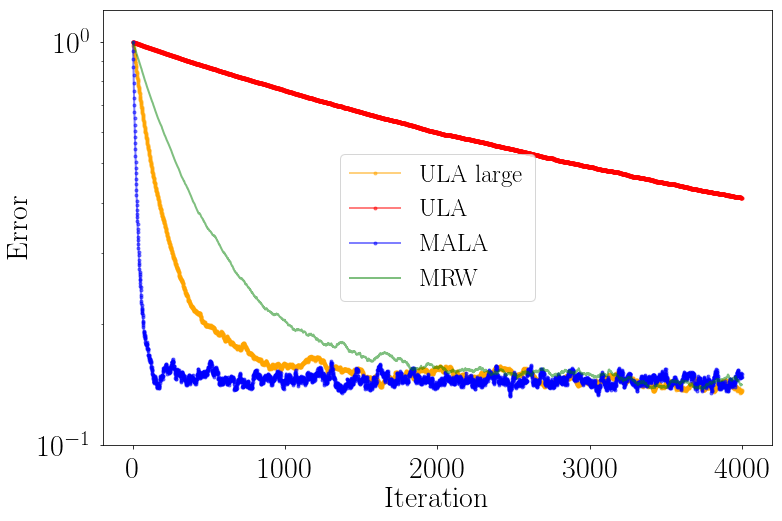

In [6]:
plot_run(0)

In [7]:
# dimensions
ds = np.array([2])
# number of iterations
nb_iters = 10000
# number of samples
nb_exps = 100
# number of training data samples
n = 50

trace_ula_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_ula_02_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_ula_002_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_mala_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_rwmh_all = np.zeros((ds.shape[0], nb_iters, nb_exps))


In [8]:
for j, d in enumerate(ds):
    # tuning parameter for the prior
    lam = 3.*d/np.pi**2
    # data generation
    X = np.random.binomial(1, 0.5, (n, d)) * 2 -1
    X = X/np.sqrt((X * X).mean(axis=1))[:, None]
    theta_true = np.ones(d)
    h_true = X.dot(theta_true)
    r_true = 1./(1.+np.exp(-h_true))
    Y = np.random.binomial(1, r_true)
    
    L = (lam + 0.25*n)
    m = (lam) 
    kappa = L/m
    
    print "start simulation for logistic regression preconditioned case: d = %d, m = %0.2f, L = %0.2f, kappa = %0.2f, lam = %0.2f" %(d, m, L, kappa, lam)

    def error_first_coordinate(x_curr):
        return x_curr[:, 0]
    

    # initialization
    init_distr = 1./np.sqrt(L)*np.random.randn(nb_exps, d)
        

    # calculating the inverse sqrt of Sigma
    U, S, V = np.linalg.svd(X/np.sqrt(Y.shape[0]), full_matrices=0)
    SigmaSqrtInv = V.T.dot(np.diag(1./S)).dot(V)
        

    def grad_f_local(x):
        return grad_g(x, X, Y, lam, SigmaSqrtInv)

    def f_local(x):
        return density_g(x, X, Y, lam, SigmaSqrtInv)

    trace_ula_all[j], x_ula = mcmc.ula(init_distr, grad_f_local, error_first_coordinate, epsilon=1.0, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_ula_02_all[j], x_ula_02 = mcmc.ula(init_distr, grad_f_local, error_first_coordinate, epsilon=0.2, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_ula_002_all[j], x_ula_002 = mcmc.ula(init_distr, grad_f_local, error_first_coordinate, epsilon=0.1, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_mala_all[j], x_mala = mcmc.mala(init_distr, grad_f_local, f_local, error_first_coordinate, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_rwmh_all[j], x_rwmh = mcmc.rwmh(init_distr, f_local, error_first_coordinate, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

start simulation for logistic regression preconditioned case: d = 2, m = 0.61, L = 13.11, kappa = 21.56, lam = 0.61


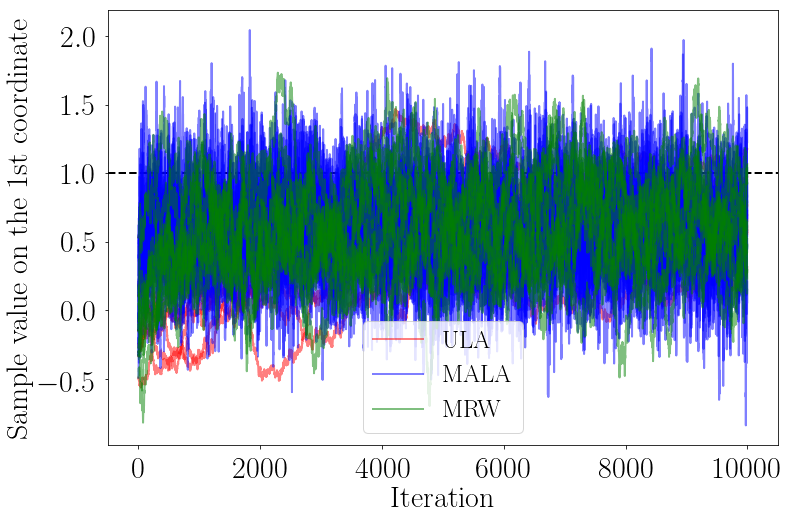

In [9]:
# traceplot
plt.figure(figsize=(12., 8.))
nb_plot_iters = 10000
plt.axhline(1, color='k', ls='dashed')
for i in range(10):
    if i == 0:
        plt.plot(trace_ula_02_all[0, :nb_plot_iters, i], color='r', alpha = 0.5, label='ULA')
    else:
        plt.plot(trace_ula_02_all[0, :nb_plot_iters, i], color='r', alpha = 0.5)
for i in range(10):
    if i == 0:
        plt.plot(trace_mala_all[0, :nb_plot_iters, i], color='b', alpha = 0.5, label='MALA')
    else:
        plt.plot(trace_mala_all[0, :nb_plot_iters, i], color='b', alpha = 0.5)
for i in range(10):
    if i == 0:
        plt.plot(trace_rwmh_all[0, :nb_plot_iters, i], color='g', alpha = 0.5, label='MRW')
    else:
        plt.plot(trace_rwmh_all[0, :nb_plot_iters, i], color='g', alpha = 0.5)
        


plt.xlabel("Iteration")
plt.ylabel("Sample value on the 1st coordinate")

plt.legend()

plt.savefig(save_path+'traceplot_logistic_regression_precondition_all.pdf')
plt.show()

### Autocorrelation plot

In [10]:
nb_lags = 6000
nb_burnin = 1000
autocorr_ula_02 = np.ones(nb_lags)
autocorr_mala = np.ones(nb_lags)
autocorr_rwmh = np.ones(nb_lags)

ith_run = 2

for i in range(1, nb_lags):
    autocorr_ula_02[i] = np.corrcoef(trace_ula_02_all[0, nb_burnin+i:, ith_run], trace_ula_02_all[0, nb_burnin:-i, ith_run])[0, 1]
    autocorr_mala[i] = np.corrcoef(trace_mala_all[0, nb_burnin+i:, ith_run], trace_mala_all[0, nb_burnin:-i, ith_run])[0, 1]
    autocorr_rwmh[i] = np.corrcoef(trace_rwmh_all[0, nb_burnin+i:, ith_run], trace_rwmh_all[0, nb_burnin:-i, ith_run])[0, 1]

/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:609: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markevery != every:


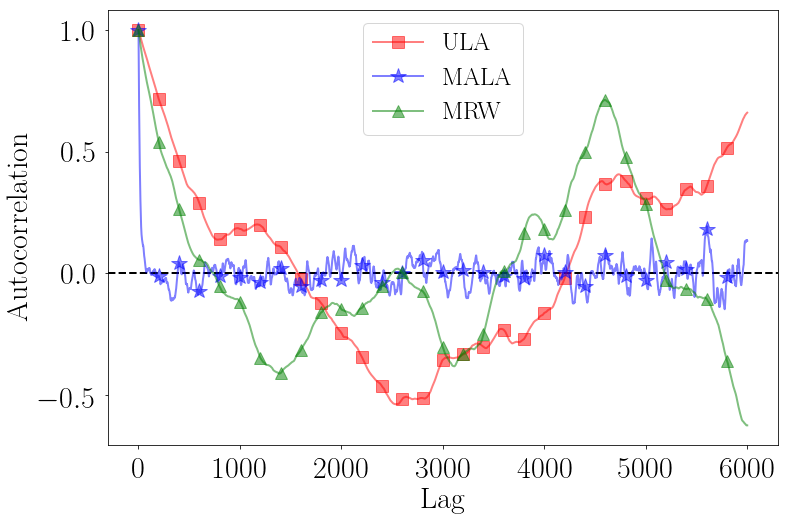

In [11]:
# autocorrelation plot
plt.figure(figsize=(12., 8.))
plt.axhline(0, color='k', ls='dashed')
markers_on = np.arange(0, nb_lags, 200)
plt.plot(autocorr_ula_02, '-rs', alpha = 0.5, label='ULA', markevery=markers_on,markersize=12.)
plt.plot(autocorr_mala, '-b*', alpha = 0.5, label='MALA', markevery=markers_on,markersize=16.)
plt.plot(autocorr_rwmh, '-g^', alpha = 0.5, label='MRW', markevery=markers_on,markersize=12.)



plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

plt.legend()
plt.savefig(save_path+'autocorrelationplot_logistic_regression_precondition_all.pdf')
plt.show()